In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model_2flares2ars, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares2ars

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
tstamp = '13_01_2020_11_28'

In [3]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [4]:
R_jup,R_sun

(<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal Jupiter equatorial radius' value=71492000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>,
 <<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar radius' value=695700000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>)

In [5]:
lcs = pd.Series({"rad":pd.Series([(2.1*R_jup/R_sun).decompose().value]),
                "Prot_d":pd.Series([2.84/24]),
                "vsini_kms":pd.Series([49.2]),
                "e_vsini_kms":pd.Series([4.9]),})
get_incl(lcs), lcs.rad.values

(rad            0    0.215802
 dtype: float64
 Prot_d         0    0.118333
 dtype: float64
 vsini_kms          0    49.2
 dtype: float64
 e_vsini_kms         0    4.9
 dtype: float64
 incl               [0.5624355126392725 rad]
 incl_err              [0.06277851710766706]
 dtype: object, array([0.21580164]))

In [6]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [7]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [8]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [9]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[2]
target

ID                            237880881
QCS                                   1
typ                                 slc
cadence_min                           2
mission                            tess
prefix                              TIC
origin                          generic
h_mission                          TESS
SpT                                  M5
view_start                         1331
view_stop                        1333.5
view_min                            560
view_max                            700
BJDoff                          2457000
tstart                           1331.7
ampl_min                            NaN
ampl_max                            NaN
RA                               19.528
Dec                            -62.9831
J                                 11.53
R                                   NaN
Gaia_G                          14.9796
vsini_kms                          14.4
e_vsini_kms                         2.6
Prot_d                          0.35125


In [10]:
# from altaipony.altai import find_iterative_median
# from altaipony.flarelc import FlareLightCurve
# from funcs.custom_detrending import refine_detrended_flux_err
# from funcs.multiperiod import remove_sinusoidal
# from funcs.helper import fetch_lightcurve

# flck = fetch_lightcurve(target)

# t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
# print(t)
# F = FlareLightCurve(time=t, detrended_flux=sflux, 
#                     detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
# print(F.detrended_flux_err)
# flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
#                                      std_rolling_window_length=15, pad=25)

# choice = (t > target.view_start) & (t < target.view_stop) 
# # only one flare in TIC 237 : + 1.56 - 1.
# t = t[choice]
# flux = sflux[choice]
# flux_err = np.nanmean(flcd.detrended_flux_err)
# median = np.nanmean(find_iterative_median(F).it_med)
# phi = (t - t[0])/target.Prot_d * 2 * np.pi

# pd.DataFrame({"phi":phi,"flux":flux, "t":t,
#               "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
#                                                              index=False)
# median

(10, 25)

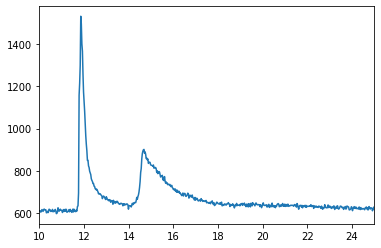

In [11]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(phi,flux)
plt.xlim(10,25)

In [12]:

phi_a = (11.8,(target.t0 - t[0])/target.Prot_d * 2 * np.pi)
theta_a = (49*np.pi/180, 59*np.pi/180)
a = (1.5, target.ampl)
fwhm = (0.5, target.dur /target.Prot_d * 2 * np.pi/5)
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 240 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = (phi[-1], phi[-1])
for _a in a:
    radius = calculate_angular_radius(Fth, _a, qlum, R)
    print(radius)
theta_a, i_mu, phi_a


20.9253963026697
11.485683712824796


((0.8552113334772214, 1.0297442586766543),
 0.3718561470554695,
 (11.8, 14.724101266474062))

(600, 1000)

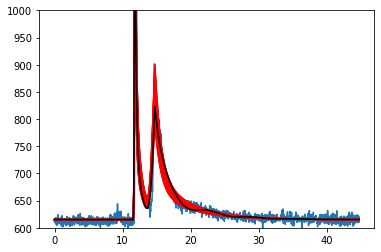

In [13]:
plt.plot(phi,flux)
for i in range(0,360,20):
    plt.plot(phi, full_model_2flares2ars(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=1,)
plt.plot(phi, full_model_2flares2ars(phi_a, theta_a, a, fwhm, i_mu, phi0=240 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(600,1000)

### Save inits

In [14]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
    f.write(firstout)
    f.write(out)

## Run MCMC

In [15]:

inits = np.array([*phi_a, *theta_a, *a, *fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 10))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares2ars,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [16]:

sampler.run_mcmc(pos, 50, progress=True, store=True);

100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


In [26]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

Initial size: 54


In [27]:
tstamp, target.ID

('13_01_2020_11_28', 237880881)

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares2ars, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))

  0%|          | 233/50000 [17:37<63:59:08,  4.63s/it]

INF PRIOR


  0%|          | 236/50000 [17:51<64:00:45,  4.63s/it]

INF PRIOR


  0%|          | 247/50000 [18:42<64:27:56,  4.66s/it]

INF PRIOR


  1%|          | 253/50000 [19:10<64:40:33,  4.68s/it]

INF PRIOR


  1%|          | 277/50000 [21:05<65:23:45,  4.73s/it]

INF PRIOR


  1%|          | 280/50000 [21:19<65:56:23,  4.77s/it]

INF PRIOR


  1%|          | 281/50000 [21:24<66:41:19,  4.83s/it]

INF PRIOR


  1%|          | 282/50000 [21:29<65:54:53,  4.77s/it]

INF PRIOR
INF PRIOR


  1%|          | 284/50000 [21:38<65:26:46,  4.74s/it]

INF PRIOR


  1%|          | 285/50000 [21:43<64:52:24,  4.70s/it]

INF PRIOR
INF PRIOR


  1%|          | 288/50000 [21:57<66:19:30,  4.80s/it]

INF PRIOR
INF PRIOR


  1%|          | 289/50000 [22:01<65:01:58,  4.71s/it]

INF PRIOR
INF PRIOR


  1%|          | 292/50000 [22:15<64:35:53,  4.68s/it]

INF PRIOR


  1%|          | 293/50000 [22:20<64:43:28,  4.69s/it]

INF PRIOR
INF PRIOR


  1%|          | 294/50000 [22:25<64:02:01,  4.64s/it]

INF PRIOR


  1%|          | 296/50000 [22:34<63:42:30,  4.61s/it]

INF PRIOR


  1%|          | 298/50000 [22:43<64:34:15,  4.68s/it]

INF PRIOR
INF PRIOR


  1%|          | 299/50000 [22:48<63:27:57,  4.60s/it]

INF PRIOR


  1%|          | 300/50000 [22:52<63:15:03,  4.58s/it]

INF PRIOR


  1%|          | 301/50000 [22:57<63:12:36,  4.58s/it]

INF PRIOR


  1%|          | 303/50000 [23:06<64:47:04,  4.69s/it]

INF PRIOR


  1%|          | 304/50000 [23:11<64:39:23,  4.68s/it]

INF PRIOR


  1%|          | 305/50000 [23:16<64:37:27,  4.68s/it]

INF PRIOR


  1%|          | 307/50000 [23:25<64:05:41,  4.64s/it]

INF PRIOR


  1%|          | 310/50000 [23:39<65:27:26,  4.74s/it]

INF PRIOR


  1%|          | 312/50000 [23:48<63:55:59,  4.63s/it]

INF PRIOR


  1%|          | 315/50000 [24:02<62:52:34,  4.56s/it]

INF PRIOR


  1%|          | 325/50000 [24:47<62:41:11,  4.54s/it]

INF PRIOR


  1%|          | 331/50000 [25:15<62:56:20,  4.56s/it]

INF PRIOR


  1%|          | 347/50000 [26:28<64:57:01,  4.71s/it]

INF PRIOR


  1%|          | 348/50000 [26:33<64:38:56,  4.69s/it]

INF PRIOR


  1%|          | 351/50000 [26:46<62:00:19,  4.50s/it]

INF PRIOR


  1%|          | 355/50000 [27:04<62:15:15,  4.51s/it]

INF PRIOR


  1%|          | 359/50000 [27:23<63:35:43,  4.61s/it]

INF PRIOR


  1%|          | 360/50000 [27:27<63:04:21,  4.57s/it]

INF PRIOR


  1%|          | 361/50000 [27:31<61:42:38,  4.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 363/50000 [27:40<60:15:22,  4.37s/it]

INF PRIOR


  1%|          | 366/50000 [27:53<60:03:12,  4.36s/it]

INF PRIOR


  1%|          | 367/50000 [27:57<59:53:10,  4.34s/it]

INF PRIOR


  1%|          | 368/50000 [28:02<60:19:33,  4.38s/it]

INF PRIOR


  1%|          | 369/50000 [28:06<60:36:25,  4.40s/it]

INF PRIOR
INF PRIOR


  1%|          | 370/50000 [28:10<60:29:58,  4.39s/it]

INF PRIOR


  1%|          | 372/50000 [28:19<61:29:38,  4.46s/it]

INF PRIOR


  1%|          | 374/50000 [28:29<61:59:08,  4.50s/it]

INF PRIOR


  1%|          | 376/50000 [28:38<63:46:53,  4.63s/it]

INF PRIOR
INF PRIOR


  1%|          | 377/50000 [28:42<63:14:21,  4.59s/it]

INF PRIOR


  1%|          | 379/50000 [28:52<63:08:51,  4.58s/it]

INF PRIOR


  1%|          | 380/50000 [28:56<62:36:35,  4.54s/it]

INF PRIOR
INF PRIOR


  1%|          | 382/50000 [29:05<60:38:17,  4.40s/it]

INF PRIOR


  1%|          | 388/50000 [29:32<62:39:52,  4.55s/it]

INF PRIOR


  1%|          | 396/50000 [30:07<61:18:43,  4.45s/it]

INF PRIOR


  1%|          | 412/50000 [31:18<62:06:59,  4.51s/it]

INF PRIOR


  1%|          | 414/50000 [31:27<61:08:11,  4.44s/it]

INF PRIOR


  1%|          | 415/50000 [31:31<61:04:08,  4.43s/it]

INF PRIOR


  1%|          | 418/50000 [31:44<59:58:51,  4.36s/it]

INF PRIOR


  1%|          | 419/50000 [31:48<59:47:13,  4.34s/it]

INF PRIOR


  1%|          | 420/50000 [31:53<59:18:29,  4.31s/it]

INF PRIOR


  1%|          | 421/50000 [31:57<58:58:04,  4.28s/it]

INF PRIOR


  1%|          | 423/50000 [32:06<59:09:01,  4.30s/it]

INF PRIOR


  1%|          | 425/50000 [32:14<59:12:30,  4.30s/it]

INF PRIOR
INF PRIOR


  1%|          | 426/50000 [32:18<59:28:38,  4.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 427/50000 [32:22<57:54:59,  4.21s/it]

INF PRIOR
INF PRIOR


  1%|          | 428/50000 [32:27<57:40:39,  4.19s/it]

INF PRIOR


  1%|          | 429/50000 [32:31<58:19:30,  4.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 430/50000 [32:35<57:02:41,  4.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 431/50000 [32:39<55:05:40,  4.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 432/50000 [32:42<54:17:12,  3.94s/it]

INF PRIOR
INF PRIOR


  1%|          | 433/50000 [32:46<54:50:23,  3.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 434/50000 [32:50<53:33:08,  3.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 435/50000 [32:54<53:54:04,  3.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 436/50000 [32:58<53:58:03,  3.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 437/50000 [33:02<53:59:19,  3.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 438/50000 [33:06<54:23:14,  3.95s/it]

INF PRIOR
INF PRIOR


  1%|          | 440/50000 [33:14<56:09:38,  4.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 441/50000 [33:18<56:28:51,  4.10s/it]

INF PRIOR


  1%|          | 442/50000 [33:23<57:34:41,  4.18s/it]

INF PRIOR
INF PRIOR


  1%|          | 443/50000 [33:27<57:15:07,  4.16s/it]

INF PRIOR


  1%|          | 444/50000 [33:31<57:49:10,  4.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 445/50000 [33:35<57:18:16,  4.16s/it]

INF PRIOR
INF PRIOR


  1%|          | 446/50000 [33:39<57:12:17,  4.16s/it]

INF PRIOR
INF PRIOR


  1%|          | 447/50000 [33:44<57:48:04,  4.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 448/50000 [33:48<57:20:32,  4.17s/it]

INF PRIOR


  1%|          | 449/50000 [33:52<58:04:24,  4.22s/it]

INF PRIOR
INF PRIOR


  1%|          | 450/50000 [33:56<58:05:42,  4.22s/it]

INF PRIOR


  1%|          | 451/50000 [34:01<58:23:22,  4.24s/it]

INF PRIOR


  1%|          | 452/50000 [34:05<59:35:34,  4.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 453/50000 [34:09<59:06:57,  4.30s/it]

INF PRIOR


  1%|          | 454/50000 [34:14<59:24:58,  4.32s/it]

INF PRIOR
INF PRIOR


  1%|          | 455/50000 [34:18<59:18:03,  4.31s/it]

INF PRIOR
INF PRIOR


  1%|          | 456/50000 [34:22<58:19:11,  4.24s/it]

INF PRIOR
INF PRIOR


  1%|          | 458/50000 [34:31<59:23:42,  4.32s/it]

INF PRIOR
INF PRIOR


  1%|          | 459/50000 [34:35<57:57:59,  4.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 460/50000 [34:39<56:27:32,  4.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 461/50000 [34:42<54:42:48,  3.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 462/50000 [34:47<55:34:27,  4.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 463/50000 [34:50<54:41:41,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 464/50000 [34:54<54:11:38,  3.94s/it]

INF PRIOR
INF PRIOR


  1%|          | 466/50000 [35:03<58:14:27,  4.23s/it]

INF PRIOR
INF PRIOR


  1%|          | 467/50000 [35:07<57:32:42,  4.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 468/50000 [35:11<56:56:34,  4.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 469/50000 [35:15<55:32:24,  4.04s/it]

INF PRIOR
INF PRIOR


  1%|          | 470/50000 [35:19<55:51:46,  4.06s/it]

INF PRIOR
INF PRIOR


  1%|          | 472/50000 [35:27<56:28:07,  4.10s/it]

INF PRIOR
INF PRIOR


  1%|          | 473/50000 [35:32<57:54:11,  4.21s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 474/50000 [35:36<56:58:00,  4.14s/it]

INF PRIOR


  1%|          | 475/50000 [35:40<58:03:15,  4.22s/it]

INF PRIOR


  1%|          | 476/50000 [35:45<58:36:29,  4.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 477/50000 [35:49<57:51:22,  4.21s/it]

INF PRIOR


  1%|          | 478/50000 [35:53<58:26:47,  4.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 479/50000 [35:57<57:30:06,  4.18s/it]

INF PRIOR
INF PRIOR


  1%|          | 480/50000 [36:01<57:39:41,  4.19s/it]

INF PRIOR
INF PRIOR


  1%|          | 481/50000 [36:06<58:00:54,  4.22s/it]

INF PRIOR
INF PRIOR


  1%|          | 482/50000 [36:10<57:47:01,  4.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 483/50000 [36:14<57:16:51,  4.16s/it]

INF PRIOR


  1%|          | 484/50000 [36:18<57:44:02,  4.20s/it]

INF PRIOR
INF PRIOR


  1%|          | 485/50000 [36:22<58:23:58,  4.25s/it]

INF PRIOR
INF PRIOR


  1%|          | 486/50000 [36:27<58:54:25,  4.28s/it]

INF PRIOR


  1%|          | 487/50000 [36:31<58:36:18,  4.26s/it]

INF PRIOR


  1%|          | 489/50000 [36:40<59:31:38,  4.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 490/50000 [36:44<57:13:59,  4.16s/it]

INF PRIOR
INF PRIOR


  1%|          | 491/50000 [36:48<57:22:08,  4.17s/it]

INF PRIOR
INF PRIOR


  1%|          | 493/50000 [36:57<60:09:17,  4.37s/it]

INF PRIOR


  1%|          | 494/50000 [37:01<59:57:34,  4.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 495/50000 [37:05<59:23:43,  4.32s/it]

INF PRIOR
INF PRIOR


  1%|          | 496/50000 [37:09<58:28:30,  4.25s/it]

INF PRIOR
INF PRIOR


  1%|          | 498/50000 [37:19<60:34:58,  4.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 499/50000 [37:23<58:46:00,  4.27s/it]

INF PRIOR
INF PRIOR


  1%|          | 500/50000 [37:27<58:23:09,  4.25s/it]

INF PRIOR


  1%|          | 501/50000 [37:31<59:36:23,  4.34s/it]

INF PRIOR


  1%|          | 502/50000 [37:36<61:20:36,  4.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 503/50000 [37:40<61:17:45,  4.46s/it]

INF PRIOR


  1%|          | 504/50000 [37:45<60:20:41,  4.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 505/50000 [37:49<58:52:17,  4.28s/it]

INF PRIOR
INF PRIOR


  1%|          | 506/50000 [37:53<58:06:30,  4.23s/it]

INF PRIOR
INF PRIOR


  1%|          | 507/50000 [37:57<58:07:10,  4.23s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 508/50000 [38:01<57:48:06,  4.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 509/50000 [38:05<56:43:37,  4.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 510/50000 [38:09<56:04:47,  4.08s/it]

INF PRIOR
INF PRIOR


  1%|          | 511/50000 [38:13<55:32:24,  4.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 512/50000 [38:17<54:53:46,  3.99s/it]

INF PRIOR


  1%|          | 513/50000 [38:21<55:44:30,  4.06s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 514/50000 [38:25<55:31:21,  4.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 515/50000 [38:29<55:07:06,  4.01s/it]

INF PRIOR
INF PRIOR


  1%|          | 516/50000 [38:33<55:25:18,  4.03s/it]

INF PRIOR
INF PRIOR


  1%|          | 517/50000 [38:37<55:42:42,  4.05s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 518/50000 [38:41<55:35:47,  4.04s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 519/50000 [38:45<54:38:39,  3.98s/it]

INF PRIOR


  1%|          | 520/50000 [38:49<55:29:00,  4.04s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 521/50000 [38:53<53:59:59,  3.93s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 522/50000 [38:57<54:35:37,  3.97s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 523/50000 [39:01<55:27:34,  4.04s/it]

INF PRIOR


  1%|          | 524/50000 [39:05<56:06:03,  4.08s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 525/50000 [39:09<55:29:56,  4.04s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 526/50000 [39:14<56:16:10,  4.09s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 527/50000 [39:18<55:29:42,  4.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 528/50000 [39:22<56:39:56,  4.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 529/50000 [39:26<57:01:33,  4.15s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 530/50000 [39:30<56:08:31,  4.09s/it]

INF PRIOR


  1%|          | 531/50000 [39:34<56:26:14,  4.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 532/50000 [39:38<56:14:20,  4.09s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 533/50000 [39:42<55:26:33,  4.03s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 534/50000 [39:46<55:11:45,  4.02s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 535/50000 [39:50<56:36:30,  4.12s/it]

INF PRIOR


  1%|          | 536/50000 [39:55<56:55:38,  4.14s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 537/50000 [39:58<53:48:55,  3.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 538/50000 [40:02<53:53:00,  3.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 539/50000 [40:06<54:41:06,  3.98s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 540/50000 [40:10<55:42:44,  4.06s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 541/50000 [40:14<54:50:31,  3.99s/it]

INF PRIOR
INF PRIOR


  1%|          | 542/50000 [40:18<55:35:33,  4.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 543/50000 [40:22<54:00:22,  3.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 544/50000 [40:26<54:29:06,  3.97s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 545/50000 [40:30<54:21:09,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 546/50000 [40:34<54:51:33,  3.99s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 547/50000 [40:38<53:32:26,  3.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 548/50000 [40:41<52:46:03,  3.84s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 549/50000 [40:45<53:29:03,  3.89s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 550/50000 [40:49<54:05:28,  3.94s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 551/50000 [40:53<54:03:27,  3.94s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 552/50000 [40:57<52:43:05,  3.84s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 553/50000 [41:01<54:18:01,  3.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 554/50000 [41:05<54:23:36,  3.96s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 555/50000 [41:10<56:10:53,  4.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 556/50000 [41:14<56:16:34,  4.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 557/50000 [41:18<55:08:02,  4.01s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 558/50000 [41:21<53:54:17,  3.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 559/50000 [41:25<54:31:12,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 560/50000 [41:30<55:24:36,  4.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 561/50000 [41:34<56:14:46,  4.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 562/50000 [41:38<55:17:32,  4.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 563/50000 [41:41<54:37:21,  3.98s/it]

INF PRIOR


  1%|          | 564/50000 [41:46<55:34:58,  4.05s/it]

INF PRIOR
INF PRIOR


  1%|          | 565/50000 [41:50<55:27:51,  4.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 566/50000 [41:53<53:22:03,  3.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 567/50000 [41:57<52:14:56,  3.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 568/50000 [42:01<52:01:41,  3.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 569/50000 [42:04<50:22:35,  3.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 570/50000 [42:08<52:02:26,  3.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 571/50000 [42:12<52:22:53,  3.82s/it]

INF PRIOR


  1%|          | 572/50000 [42:16<55:12:35,  4.02s/it]

INF PRIOR


  1%|          | 573/50000 [42:21<56:02:57,  4.08s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 574/50000 [42:24<53:54:33,  3.93s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 575/50000 [42:28<53:26:58,  3.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 576/50000 [42:32<53:46:47,  3.92s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 577/50000 [42:35<51:41:07,  3.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 578/50000 [42:39<50:37:27,  3.69s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 579/50000 [42:42<49:20:53,  3.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 580/50000 [42:46<50:35:11,  3.68s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 581/50000 [42:50<49:27:11,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 582/50000 [42:54<50:53:33,  3.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 583/50000 [42:57<50:05:24,  3.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 584/50000 [43:01<51:09:14,  3.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 585/50000 [43:05<51:43:26,  3.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 586/50000 [43:09<52:07:32,  3.80s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 587/50000 [43:13<53:00:02,  3.86s/it]

INF PRIOR


  1%|          | 588/50000 [43:17<54:06:17,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 589/50000 [43:21<54:03:18,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 590/50000 [43:25<53:08:21,  3.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 591/50000 [43:28<52:50:54,  3.85s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 592/50000 [43:32<52:40:48,  3.84s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 593/50000 [43:36<52:53:34,  3.85s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 594/50000 [43:40<53:29:07,  3.90s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 595/50000 [43:43<50:15:51,  3.66s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 596/50000 [43:47<49:22:09,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 597/50000 [43:50<49:27:24,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 598/50000 [43:54<50:24:55,  3.67s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 599/50000 [43:58<51:11:47,  3.73s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 600/50000 [44:02<51:03:14,  3.72s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 601/50000 [44:06<52:41:06,  3.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 602/50000 [44:09<51:54:35,  3.78s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 603/50000 [44:13<52:22:49,  3.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 604/50000 [44:17<51:14:13,  3.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 605/50000 [44:21<52:03:41,  3.79s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 606/50000 [44:25<52:46:13,  3.85s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 607/50000 [44:28<52:03:30,  3.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 608/50000 [44:32<51:27:54,  3.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 609/50000 [44:36<50:30:53,  3.68s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 610/50000 [44:39<50:47:44,  3.70s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 611/50000 [44:43<51:01:42,  3.72s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 612/50000 [44:47<51:08:30,  3.73s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 613/50000 [44:51<51:46:12,  3.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 614/50000 [44:54<51:37:56,  3.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 615/50000 [44:58<51:10:36,  3.73s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 616/50000 [45:02<51:10:33,  3.73s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|          | 617/50000 [45:06<51:52:39,  3.78s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 618/50000 [45:10<51:58:21,  3.79s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 619/50000 [45:13<51:36:20,  3.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|          | 620/50000 [45:17<53:23:47,  3.89s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|          | 621/50000 [45:21<54:05:05,  3.94s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 622/50000 [45:25<54:18:39,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 623/50000 [45:29<53:46:28,  3.92s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 624/50000 [45:33<53:11:03,  3.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 625/50000 [45:37<53:30:35,  3.90s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 626/50000 [45:41<52:21:02,  3.82s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|▏         | 627/50000 [45:45<53:04:03,  3.87s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 628/50000 [45:49<53:44:12,  3.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 629/50000 [45:53<54:10:31,  3.95s/it]

INF PRIOR


  1%|▏         | 630/50000 [45:57<54:23:09,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 631/50000 [46:01<54:59:25,  4.01s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 632/50000 [46:05<53:39:49,  3.91s/it]

INF PRIOR


  1%|▏         | 633/50000 [46:09<56:16:29,  4.10s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|▏         | 634/50000 [46:13<54:34:50,  3.98s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 635/50000 [46:17<53:57:58,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 636/50000 [46:20<53:38:48,  3.91s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 637/50000 [46:24<53:27:04,  3.90s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 638/50000 [46:28<53:19:17,  3.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 639/50000 [46:32<53:05:15,  3.87s/it]

INF PRIOR


  1%|▏         | 640/50000 [46:36<54:20:42,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 641/50000 [46:40<54:10:46,  3.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 642/50000 [46:44<54:03:00,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 643/50000 [46:48<52:40:11,  3.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 644/50000 [46:52<53:48:25,  3.92s/it]

INF PRIOR


  1%|▏         | 645/50000 [46:56<54:54:16,  4.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 646/50000 [47:00<54:45:07,  3.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 647/50000 [47:03<52:38:44,  3.84s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 648/50000 [47:07<52:48:37,  3.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 649/50000 [47:11<52:36:14,  3.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 650/50000 [47:15<51:43:00,  3.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 651/50000 [47:18<49:55:00,  3.64s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 652/50000 [47:22<50:27:47,  3.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 653/50000 [47:25<49:06:06,  3.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 654/50000 [47:28<47:36:50,  3.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 655/50000 [47:32<47:29:52,  3.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 656/50000 [47:35<47:59:44,  3.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 657/50000 [47:39<49:19:57,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 658/50000 [47:43<48:40:44,  3.55s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 659/50000 [47:47<50:52:02,  3.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 661/50000 [47:55<54:15:48,  3.96s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 662/50000 [47:59<54:27:19,  3.97s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 663/50000 [48:03<54:00:45,  3.94s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 664/50000 [48:07<54:57:32,  4.01s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 665/50000 [48:11<54:20:05,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 666/50000 [48:15<56:15:01,  4.10s/it]

INF PRIOR


  1%|▏         | 667/50000 [48:19<56:08:29,  4.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 668/50000 [48:23<55:08:08,  4.02s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 670/50000 [48:32<56:12:57,  4.10s/it]

INF PRIOR


  1%|▏         | 671/50000 [48:36<56:05:36,  4.09s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 673/50000 [48:44<56:15:46,  4.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 674/50000 [48:48<55:45:33,  4.07s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|▏         | 675/50000 [48:52<54:55:38,  4.01s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 676/50000 [48:56<54:16:39,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 677/50000 [48:59<53:15:37,  3.89s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 678/50000 [49:04<55:01:12,  4.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 679/50000 [49:08<54:14:52,  3.96s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 680/50000 [49:11<54:06:45,  3.95s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 681/50000 [49:16<54:58:56,  4.01s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 682/50000 [49:20<54:56:01,  4.01s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 683/50000 [49:24<55:16:27,  4.03s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 684/50000 [49:28<55:18:24,  4.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 685/50000 [49:32<55:20:29,  4.04s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 686/50000 [49:36<55:17:49,  4.04s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 687/50000 [49:40<55:21:39,  4.04s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 689/50000 [49:49<57:44:23,  4.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 690/50000 [49:52<56:37:03,  4.13s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|▏         | 691/50000 [49:56<54:59:07,  4.01s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  1%|▏         | 692/50000 [50:00<54:56:13,  4.01s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 693/50000 [50:04<55:45:13,  4.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 694/50000 [50:08<54:19:48,  3.97s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 695/50000 [50:12<55:14:01,  4.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 696/50000 [50:16<55:25:45,  4.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 697/50000 [50:20<54:55:13,  4.01s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 698/50000 [50:24<55:06:19,  4.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 700/50000 [50:33<56:14:34,  4.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 701/50000 [50:37<56:01:52,  4.09s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 702/50000 [50:41<56:19:01,  4.11s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 703/50000 [50:45<55:21:18,  4.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 704/50000 [50:49<54:45:34,  4.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 705/50000 [50:53<54:30:28,  3.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  1%|▏         | 706/50000 [50:56<53:07:08,  3.88s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 707/50000 [51:00<54:33:01,  3.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 708/50000 [51:04<54:11:17,  3.96s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 709/50000 [51:08<53:38:09,  3.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 710/50000 [51:12<53:59:29,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 711/50000 [51:16<54:04:49,  3.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 712/50000 [51:20<54:23:18,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 713/50000 [51:24<53:48:03,  3.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 714/50000 [51:28<53:43:10,  3.92s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 715/50000 [51:32<54:41:52,  4.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 716/50000 [51:36<54:14:05,  3.96s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 717/50000 [51:40<54:37:54,  3.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 718/50000 [51:44<53:33:41,  3.91s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 719/50000 [51:48<53:59:29,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 720/50000 [51:52<53:04:41,  3.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  1%|▏         | 721/50000 [51:55<51:20:35,  3.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 722/50000 [51:58<49:45:10,  3.63s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 723/50000 [52:03<53:17:18,  3.89s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 724/50000 [52:07<54:44:06,  4.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 725/50000 [52:11<53:51:42,  3.94s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 726/50000 [52:15<54:22:57,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 727/50000 [52:18<52:27:23,  3.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 728/50000 [52:22<53:19:42,  3.90s/it]

INF PRIOR


  1%|▏         | 729/50000 [52:27<54:25:56,  3.98s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 730/50000 [52:31<54:28:52,  3.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 731/50000 [52:34<53:43:30,  3.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 732/50000 [52:38<53:47:31,  3.93s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 733/50000 [52:42<53:59:55,  3.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 734/50000 [52:46<54:15:02,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 735/50000 [52:50<54:01:13,  3.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 736/50000 [52:54<52:45:29,  3.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 737/50000 [52:58<52:59:52,  3.87s/it]

INF PRIOR


  1%|▏         | 738/50000 [53:02<54:23:27,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 739/50000 [53:06<53:49:03,  3.93s/it]

INF PRIOR


  1%|▏         | 740/50000 [53:10<54:46:46,  4.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 741/50000 [53:14<54:33:07,  3.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 742/50000 [53:18<53:45:27,  3.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 743/50000 [53:22<53:38:28,  3.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 744/50000 [53:25<51:21:48,  3.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 745/50000 [53:29<51:51:43,  3.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 746/50000 [53:33<52:17:28,  3.82s/it]

INF PRIOR
INF PRIOR


  1%|▏         | 747/50000 [53:37<53:19:33,  3.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 748/50000 [53:41<54:09:54,  3.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  1%|▏         | 749/50000 [53:45<54:18:40,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 750/50000 [53:49<54:36:01,  3.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 751/50000 [53:53<54:52:03,  4.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 752/50000 [53:57<55:13:27,  4.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 753/50000 [54:01<54:20:41,  3.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 754/50000 [54:05<53:59:35,  3.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 755/50000 [54:09<54:09:00,  3.96s/it]

INF PRIOR


  2%|▏         | 756/50000 [54:13<53:31:08,  3.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 757/50000 [54:16<51:54:26,  3.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 758/50000 [54:20<52:26:46,  3.83s/it]

INF PRIOR
INF PRIOR


  2%|▏         | 759/50000 [54:24<53:15:44,  3.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 760/50000 [54:28<51:17:16,  3.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 761/50000 [54:31<51:22:21,  3.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 762/50000 [54:35<52:04:00,  3.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 763/50000 [54:39<52:04:55,  3.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 764/50000 [54:42<50:17:02,  3.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 765/50000 [54:46<50:32:26,  3.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 766/50000 [54:50<51:26:05,  3.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 767/50000 [54:54<51:02:18,  3.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 768/50000 [54:57<50:11:36,  3.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 769/50000 [55:01<49:50:52,  3.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 770/50000 [55:05<50:29:36,  3.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 771/50000 [55:08<48:15:49,  3.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 772/50000 [55:11<45:38:48,  3.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 773/50000 [55:14<45:23:15,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 774/50000 [55:17<46:08:31,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 775/50000 [55:22<48:47:18,  3.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 776/50000 [55:25<48:16:42,  3.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 777/50000 [55:29<49:12:09,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 778/50000 [55:33<50:24:21,  3.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 779/50000 [55:36<48:58:03,  3.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 780/50000 [55:39<48:44:55,  3.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 781/50000 [55:43<49:04:32,  3.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 782/50000 [55:46<47:39:19,  3.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 783/50000 [55:51<50:41:15,  3.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 784/50000 [55:54<50:09:33,  3.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 785/50000 [55:58<49:14:18,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 786/50000 [56:01<47:28:46,  3.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 787/50000 [56:04<47:51:26,  3.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 788/50000 [56:08<48:10:33,  3.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 789/50000 [56:11<45:37:17,  3.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 790/50000 [56:14<46:37:34,  3.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 791/50000 [56:18<47:27:42,  3.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 792/50000 [56:21<47:12:32,  3.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 793/50000 [56:25<46:02:33,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 794/50000 [56:28<47:29:54,  3.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 795/50000 [56:32<46:38:14,  3.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 796/50000 [56:35<45:29:22,  3.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 797/50000 [56:38<45:10:15,  3.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 798/50000 [56:41<43:38:21,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 799/50000 [56:44<43:59:23,  3.22s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 800/50000 [56:48<44:46:46,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 801/50000 [56:51<46:22:56,  3.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 802/50000 [56:55<46:46:31,  3.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 803/50000 [56:58<46:09:51,  3.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 804/50000 [57:01<46:24:09,  3.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 805/50000 [57:05<47:53:43,  3.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 806/50000 [57:08<46:48:40,  3.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 807/50000 [57:12<46:05:07,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 808/50000 [57:15<45:58:29,  3.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 809/50000 [57:18<43:43:07,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 810/50000 [57:21<42:41:05,  3.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 811/50000 [57:24<42:15:28,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 812/50000 [57:27<42:03:55,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 813/50000 [57:31<45:19:22,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 814/50000 [57:34<45:40:53,  3.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 815/50000 [57:38<46:46:00,  3.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 816/50000 [57:41<47:09:32,  3.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 817/50000 [57:44<45:44:48,  3.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 818/50000 [57:47<42:45:26,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 819/50000 [57:50<43:13:59,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 820/50000 [57:54<46:20:01,  3.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 821/50000 [57:57<45:52:42,  3.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 822/50000 [58:01<46:36:24,  3.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 823/50000 [58:04<46:01:12,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 824/50000 [58:08<46:02:45,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 825/50000 [58:11<45:49:09,  3.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 826/50000 [58:14<44:55:24,  3.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 827/50000 [58:17<43:08:03,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 828/50000 [58:20<43:01:32,  3.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 829/50000 [58:23<41:46:44,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 830/50000 [58:26<43:14:04,  3.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 831/50000 [58:29<42:57:48,  3.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 832/50000 [58:33<44:06:15,  3.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 833/50000 [58:37<47:17:48,  3.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 834/50000 [58:40<45:04:06,  3.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 835/50000 [58:43<44:51:00,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 836/50000 [58:46<45:07:23,  3.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 837/50000 [58:50<45:19:17,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 838/50000 [58:53<44:53:29,  3.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 839/50000 [58:56<45:18:59,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 840/50000 [59:00<46:43:09,  3.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 841/50000 [59:04<48:12:01,  3.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 842/50000 [59:07<46:57:43,  3.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 843/50000 [59:11<47:38:05,  3.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 844/50000 [59:14<47:38:18,  3.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 845/50000 [59:18<49:27:09,  3.62s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 846/50000 [59:21<48:07:13,  3.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 847/50000 [59:25<48:05:50,  3.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 848/50000 [59:28<47:37:04,  3.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 849/50000 [59:31<45:26:22,  3.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 850/50000 [59:35<46:18:34,  3.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 851/50000 [59:37<43:31:51,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 852/50000 [59:40<41:35:44,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 853/50000 [59:44<42:59:58,  3.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 854/50000 [59:47<44:46:23,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 855/50000 [59:50<43:16:55,  3.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 856/50000 [59:53<43:37:46,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 857/50000 [59:56<41:37:06,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 858/50000 [1:00:00<43:16:39,  3.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 859/50000 [1:00:03<42:39:56,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 860/50000 [1:00:05<41:50:04,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 861/50000 [1:00:09<44:56:36,  3.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 862/50000 [1:00:13<44:49:35,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 863/50000 [1:00:15<42:41:06,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 864/50000 [1:00:18<42:54:33,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 865/50000 [1:00:22<42:23:18,  3.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 866/50000 [1:00:24<40:20:57,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 867/50000 [1:00:27<40:26:09,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 868/50000 [1:00:30<40:42:58,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 869/50000 [1:00:34<43:36:25,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 870/50000 [1:00:37<45:25:01,  3.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 871/50000 [1:00:42<48:44:45,  3.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 872/50000 [1:00:45<49:47:58,  3.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 873/50000 [1:00:50<52:44:23,  3.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 874/50000 [1:00:54<53:47:48,  3.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 875/50000 [1:00:57<49:11:47,  3.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 876/50000 [1:01:00<49:01:37,  3.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 877/50000 [1:01:03<46:05:17,  3.38s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 878/50000 [1:01:06<45:18:58,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 879/50000 [1:01:10<44:41:31,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 880/50000 [1:01:13<44:16:16,  3.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 881/50000 [1:01:15<42:03:24,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 882/50000 [1:01:18<41:15:58,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 883/50000 [1:01:21<40:58:37,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 884/50000 [1:01:25<44:10:39,  3.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 885/50000 [1:01:28<43:34:45,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 886/50000 [1:01:31<40:59:37,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 887/50000 [1:01:34<42:38:20,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 888/50000 [1:01:37<43:42:20,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 889/50000 [1:01:40<41:09:14,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 890/50000 [1:01:43<39:53:27,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 891/50000 [1:01:46<40:35:55,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 892/50000 [1:01:48<38:57:25,  2.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 893/50000 [1:01:51<38:21:36,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 894/50000 [1:01:55<41:35:13,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 895/50000 [1:01:58<42:03:01,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 896/50000 [1:02:01<41:42:36,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 897/50000 [1:02:04<42:13:01,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 898/50000 [1:02:07<41:30:27,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 899/50000 [1:02:10<41:31:16,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 900/50000 [1:02:13<40:49:32,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 901/50000 [1:02:16<39:17:16,  2.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 902/50000 [1:02:19<39:54:02,  2.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 903/50000 [1:02:22<40:55:12,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 904/50000 [1:02:25<40:24:25,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 905/50000 [1:02:28<42:10:14,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 906/50000 [1:02:31<42:50:07,  3.14s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 907/50000 [1:02:34<40:24:53,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 908/50000 [1:02:36<37:08:25,  2.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 909/50000 [1:02:39<37:29:41,  2.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 910/50000 [1:02:42<39:47:22,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 911/50000 [1:02:46<42:09:28,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 912/50000 [1:02:49<45:09:09,  3.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 913/50000 [1:02:53<44:33:53,  3.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 914/50000 [1:02:56<44:16:28,  3.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 915/50000 [1:02:59<45:12:25,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 916/50000 [1:03:02<44:00:05,  3.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 917/50000 [1:03:06<44:00:01,  3.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 918/50000 [1:03:09<43:05:07,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 919/50000 [1:03:11<41:38:50,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 920/50000 [1:03:14<41:23:26,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 921/50000 [1:03:18<44:37:55,  3.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 922/50000 [1:03:22<45:52:03,  3.36s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 923/50000 [1:03:25<47:01:46,  3.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 924/50000 [1:03:29<48:24:43,  3.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 925/50000 [1:03:32<47:05:11,  3.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 926/50000 [1:03:36<46:56:38,  3.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 927/50000 [1:03:39<46:14:02,  3.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 928/50000 [1:03:43<47:49:24,  3.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 929/50000 [1:03:46<47:17:17,  3.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 930/50000 [1:03:50<48:15:16,  3.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 931/50000 [1:03:54<49:04:37,  3.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 932/50000 [1:03:56<45:35:30,  3.34s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 933/50000 [1:04:00<44:50:27,  3.29s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 934/50000 [1:04:03<45:55:21,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 935/50000 [1:04:07<46:14:01,  3.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 936/50000 [1:04:10<46:47:31,  3.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 937/50000 [1:04:13<46:24:19,  3.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 938/50000 [1:04:17<46:10:20,  3.39s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 939/50000 [1:04:20<46:42:22,  3.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 940/50000 [1:04:23<44:19:24,  3.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 941/50000 [1:04:27<46:33:03,  3.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 942/50000 [1:04:31<47:48:54,  3.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 943/50000 [1:04:35<50:43:46,  3.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 944/50000 [1:04:38<48:36:16,  3.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 945/50000 [1:04:42<48:11:05,  3.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 946/50000 [1:04:45<46:44:48,  3.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 947/50000 [1:04:49<48:08:16,  3.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 948/50000 [1:04:52<46:23:33,  3.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 949/50000 [1:04:55<44:33:06,  3.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 950/50000 [1:04:57<41:58:53,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 951/50000 [1:05:00<38:34:28,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 952/50000 [1:05:03<40:19:16,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 953/50000 [1:05:06<39:32:57,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 954/50000 [1:05:08<39:46:15,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 955/50000 [1:05:12<42:34:10,  3.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 956/50000 [1:05:16<44:01:17,  3.23s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 957/50000 [1:05:19<43:29:35,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 958/50000 [1:05:22<42:05:07,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 959/50000 [1:05:24<41:04:53,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 960/50000 [1:05:27<38:41:32,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 961/50000 [1:05:30<38:17:43,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 962/50000 [1:05:32<38:35:01,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 963/50000 [1:05:35<38:34:53,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 964/50000 [1:05:38<40:12:03,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 965/50000 [1:05:42<40:42:52,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 966/50000 [1:05:44<39:07:56,  2.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 967/50000 [1:05:47<37:48:18,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 968/50000 [1:05:49<37:27:13,  2.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 969/50000 [1:05:53<39:46:03,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 970/50000 [1:05:56<39:26:49,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 971/50000 [1:05:58<39:09:42,  2.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 972/50000 [1:06:01<39:13:39,  2.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 973/50000 [1:06:04<39:43:57,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 974/50000 [1:06:08<40:59:33,  3.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 975/50000 [1:06:10<40:28:43,  2.97s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 976/50000 [1:06:14<41:43:56,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 977/50000 [1:06:17<41:14:31,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 978/50000 [1:06:19<40:08:23,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 979/50000 [1:06:23<42:24:16,  3.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 980/50000 [1:06:25<40:11:06,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 981/50000 [1:06:28<37:30:41,  2.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 982/50000 [1:06:30<36:42:41,  2.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 983/50000 [1:06:33<37:34:43,  2.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 984/50000 [1:06:37<39:56:20,  2.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 985/50000 [1:06:39<39:49:10,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 986/50000 [1:06:43<42:00:11,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 987/50000 [1:06:46<41:27:46,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 988/50000 [1:06:48<37:34:39,  2.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 989/50000 [1:06:50<35:32:11,  2.61s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 990/50000 [1:06:53<37:22:20,  2.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 991/50000 [1:06:56<37:50:38,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 992/50000 [1:06:59<38:50:11,  2.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 993/50000 [1:07:02<38:05:03,  2.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 994/50000 [1:07:05<38:01:42,  2.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 995/50000 [1:07:07<37:33:58,  2.76s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 996/50000 [1:07:11<40:07:45,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 997/50000 [1:07:14<39:34:47,  2.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 998/50000 [1:07:17<40:18:54,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 999/50000 [1:07:19<39:00:57,  2.87s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1000/50000 [1:07:22<39:54:19,  2.93s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1001/50000 [1:07:25<38:20:13,  2.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1002/50000 [1:07:28<38:18:34,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1003/50000 [1:07:31<38:50:35,  2.85s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1004/50000 [1:07:34<39:49:27,  2.93s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1005/50000 [1:07:36<38:17:45,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1006/50000 [1:07:39<36:44:15,  2.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1007/50000 [1:07:42<39:30:00,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1008/50000 [1:07:44<37:00:29,  2.72s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1009/50000 [1:07:48<40:35:31,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1010/50000 [1:07:51<39:59:01,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1011/50000 [1:07:54<40:05:07,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1012/50000 [1:07:57<40:04:54,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1013/50000 [1:08:00<40:02:02,  2.94s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1014/50000 [1:08:02<39:16:13,  2.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1015/50000 [1:08:06<41:37:51,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1016/50000 [1:08:09<43:09:58,  3.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1017/50000 [1:08:12<42:46:30,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1018/50000 [1:08:15<42:00:47,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1019/50000 [1:08:19<43:33:09,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1020/50000 [1:08:22<44:06:08,  3.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1021/50000 [1:08:25<43:02:38,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1022/50000 [1:08:29<45:35:02,  3.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1023/50000 [1:08:32<45:37:27,  3.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1024/50000 [1:08:36<45:16:24,  3.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1025/50000 [1:08:39<45:52:58,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1026/50000 [1:08:42<45:51:53,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1027/50000 [1:08:46<46:47:23,  3.44s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1028/50000 [1:08:49<45:56:40,  3.38s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1029/50000 [1:08:52<42:42:42,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1030/50000 [1:08:55<42:31:09,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1031/50000 [1:08:58<40:39:17,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1032/50000 [1:09:00<37:49:53,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1033/50000 [1:09:03<38:34:47,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1034/50000 [1:09:06<41:15:08,  3.03s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1035/50000 [1:09:09<40:20:56,  2.97s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1036/50000 [1:09:12<41:10:49,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1037/50000 [1:09:15<40:46:18,  3.00s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1038/50000 [1:09:18<41:08:30,  3.03s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1039/50000 [1:09:22<42:05:32,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1040/50000 [1:09:24<40:01:52,  2.94s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1041/50000 [1:09:27<39:56:53,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1042/50000 [1:09:30<38:24:58,  2.82s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1043/50000 [1:09:32<37:50:12,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1044/50000 [1:09:36<40:07:01,  2.95s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1045/50000 [1:09:38<39:27:17,  2.90s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1046/50000 [1:09:41<39:05:02,  2.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1047/50000 [1:09:45<41:33:54,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1048/50000 [1:09:48<42:42:37,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1049/50000 [1:09:51<41:15:53,  3.03s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1050/50000 [1:09:54<42:29:00,  3.12s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1051/50000 [1:09:57<41:13:35,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1052/50000 [1:10:00<41:21:20,  3.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1053/50000 [1:10:03<39:25:59,  2.90s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1054/50000 [1:10:06<42:46:03,  3.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1055/50000 [1:10:09<41:41:09,  3.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1056/50000 [1:10:12<42:20:38,  3.11s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1057/50000 [1:10:15<40:36:41,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1058/50000 [1:10:17<37:43:29,  2.77s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1059/50000 [1:10:20<38:22:26,  2.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1060/50000 [1:10:24<39:57:15,  2.94s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1061/50000 [1:10:27<42:37:54,  3.14s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1062/50000 [1:10:30<40:15:17,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1063/50000 [1:10:33<40:08:44,  2.95s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1064/50000 [1:10:35<38:34:53,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1065/50000 [1:10:39<41:41:37,  3.07s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1066/50000 [1:10:41<39:34:26,  2.91s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1067/50000 [1:10:44<39:45:09,  2.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1068/50000 [1:10:48<41:11:16,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1069/50000 [1:10:50<39:45:10,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1070/50000 [1:10:53<40:00:06,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1071/50000 [1:10:56<39:05:57,  2.88s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1072/50000 [1:10:59<38:51:20,  2.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1073/50000 [1:11:02<38:43:35,  2.85s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1074/50000 [1:11:05<39:42:33,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1075/50000 [1:11:07<38:46:21,  2.85s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1076/50000 [1:11:10<36:27:31,  2.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1077/50000 [1:11:12<32:44:23,  2.41s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1078/50000 [1:11:14<33:57:10,  2.50s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1079/50000 [1:11:17<34:11:06,  2.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1080/50000 [1:11:20<36:04:38,  2.65s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1081/50000 [1:11:23<36:39:59,  2.70s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1082/50000 [1:11:26<39:48:07,  2.93s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1083/50000 [1:11:29<39:19:10,  2.89s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1084/50000 [1:11:31<38:22:38,  2.82s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1085/50000 [1:11:34<36:14:44,  2.67s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1086/50000 [1:11:37<39:00:48,  2.87s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1087/50000 [1:11:40<40:08:45,  2.95s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1088/50000 [1:11:43<39:08:51,  2.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1089/50000 [1:11:46<39:52:39,  2.94s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1090/50000 [1:11:49<39:33:33,  2.91s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1091/50000 [1:11:51<37:11:36,  2.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1092/50000 [1:11:54<36:14:36,  2.67s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1093/50000 [1:11:57<37:20:16,  2.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1094/50000 [1:12:00<38:10:19,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1095/50000 [1:12:02<37:48:40,  2.78s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1096/50000 [1:12:05<37:21:43,  2.75s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1097/50000 [1:12:08<36:20:48,  2.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1098/50000 [1:12:10<36:59:59,  2.72s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1099/50000 [1:12:13<34:43:34,  2.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1100/50000 [1:12:15<35:25:53,  2.61s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1101/50000 [1:12:18<36:52:46,  2.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1102/50000 [1:12:21<37:26:48,  2.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1103/50000 [1:12:24<37:02:07,  2.73s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1104/50000 [1:12:26<35:51:36,  2.64s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1105/50000 [1:12:29<36:33:06,  2.69s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1106/50000 [1:12:31<34:53:17,  2.57s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1107/50000 [1:12:34<37:07:17,  2.73s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1108/50000 [1:12:37<38:05:35,  2.80s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1109/50000 [1:12:40<38:15:02,  2.82s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1110/50000 [1:12:43<38:02:40,  2.80s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1111/50000 [1:12:46<39:24:37,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1112/50000 [1:12:48<34:56:19,  2.57s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1113/50000 [1:12:51<37:02:32,  2.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1114/50000 [1:12:54<38:37:04,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1115/50000 [1:12:58<40:53:18,  3.01s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1116/50000 [1:13:01<41:20:45,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1117/50000 [1:13:04<41:09:03,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1118/50000 [1:13:07<40:50:20,  3.01s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1119/50000 [1:13:10<41:38:43,  3.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1120/50000 [1:13:12<37:25:15,  2.76s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1121/50000 [1:13:15<38:16:07,  2.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1122/50000 [1:13:17<37:13:07,  2.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1123/50000 [1:13:20<35:25:14,  2.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1124/50000 [1:13:23<38:01:32,  2.80s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1125/50000 [1:13:26<38:09:01,  2.81s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1126/50000 [1:13:29<39:38:45,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1127/50000 [1:13:32<40:57:19,  3.02s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1128/50000 [1:13:35<41:22:50,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1129/50000 [1:13:38<40:31:38,  2.99s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1130/50000 [1:13:41<40:26:07,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1131/50000 [1:13:44<38:46:59,  2.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1132/50000 [1:13:46<38:39:00,  2.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1133/50000 [1:13:50<41:41:07,  3.07s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1134/50000 [1:13:53<40:07:17,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1135/50000 [1:13:56<39:33:12,  2.91s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1136/50000 [1:13:58<37:45:00,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1137/50000 [1:14:01<38:30:26,  2.84s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1138/50000 [1:14:04<39:42:13,  2.93s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1139/50000 [1:14:07<40:04:40,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1140/50000 [1:14:10<38:29:36,  2.84s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1141/50000 [1:14:13<42:05:57,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1142/50000 [1:14:16<39:58:29,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1143/50000 [1:14:18<36:20:24,  2.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1144/50000 [1:14:21<37:31:29,  2.77s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1145/50000 [1:14:24<37:12:14,  2.74s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1146/50000 [1:14:26<35:23:57,  2.61s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1147/50000 [1:14:28<33:06:11,  2.44s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1148/50000 [1:14:31<36:20:04,  2.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1149/50000 [1:14:34<38:18:31,  2.82s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1150/50000 [1:14:38<39:58:09,  2.95s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1151/50000 [1:14:41<40:36:06,  2.99s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1152/50000 [1:14:43<39:00:30,  2.87s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1153/50000 [1:14:46<39:21:08,  2.90s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1154/50000 [1:14:48<34:42:28,  2.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1155/50000 [1:14:51<36:51:18,  2.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1156/50000 [1:14:54<38:24:27,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1157/50000 [1:14:57<36:11:56,  2.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1158/50000 [1:15:00<37:24:01,  2.76s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1159/50000 [1:15:02<36:38:26,  2.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1160/50000 [1:15:05<37:45:09,  2.78s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1161/50000 [1:15:08<38:28:17,  2.84s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1162/50000 [1:15:11<37:24:51,  2.76s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1163/50000 [1:15:13<36:35:25,  2.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1164/50000 [1:15:16<35:32:00,  2.62s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1165/50000 [1:15:18<34:09:48,  2.52s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1166/50000 [1:15:21<34:29:01,  2.54s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1167/50000 [1:15:23<34:09:58,  2.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1168/50000 [1:15:27<38:34:48,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1169/50000 [1:15:30<39:34:27,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1170/50000 [1:15:33<40:18:20,  2.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1171/50000 [1:15:37<43:47:26,  3.23s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1172/50000 [1:15:40<42:49:43,  3.16s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1173/50000 [1:15:42<40:23:59,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1174/50000 [1:15:44<37:34:32,  2.77s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1175/50000 [1:15:47<37:45:46,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1176/50000 [1:15:50<36:51:46,  2.72s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1177/50000 [1:15:53<39:59:52,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1178/50000 [1:15:56<39:28:31,  2.91s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1179/50000 [1:15:59<40:42:47,  3.00s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1180/50000 [1:16:02<40:40:46,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1181/50000 [1:16:06<42:04:32,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1182/50000 [1:16:09<42:29:24,  3.13s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1183/50000 [1:16:12<40:46:11,  3.01s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1184/50000 [1:16:14<39:54:25,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1185/50000 [1:16:17<39:17:18,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1186/50000 [1:16:20<40:00:28,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1187/50000 [1:16:23<41:00:28,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1188/50000 [1:16:26<39:54:58,  2.94s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1189/50000 [1:16:29<40:02:10,  2.95s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1190/50000 [1:16:32<39:34:37,  2.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1191/50000 [1:16:35<39:34:12,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1192/50000 [1:16:37<37:32:02,  2.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1193/50000 [1:16:40<38:43:32,  2.86s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1194/50000 [1:16:44<40:41:24,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1195/50000 [1:16:46<39:16:52,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1196/50000 [1:16:49<37:23:15,  2.76s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1197/50000 [1:16:52<40:04:28,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1198/50000 [1:16:56<41:15:31,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1199/50000 [1:16:58<38:14:11,  2.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1200/50000 [1:17:01<38:57:32,  2.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1201/50000 [1:17:04<40:31:27,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1202/50000 [1:17:07<40:00:24,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1203/50000 [1:17:10<40:33:24,  2.99s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1204/50000 [1:17:13<42:02:28,  3.10s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1205/50000 [1:17:17<42:24:40,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1206/50000 [1:17:19<40:07:38,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1207/50000 [1:17:22<40:39:26,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1208/50000 [1:17:26<42:34:39,  3.14s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1209/50000 [1:17:29<42:53:19,  3.16s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1210/50000 [1:17:32<42:45:42,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1211/50000 [1:17:35<40:52:19,  3.02s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1212/50000 [1:17:38<41:12:21,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1213/50000 [1:17:41<42:26:16,  3.13s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1214/50000 [1:17:45<43:51:56,  3.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1215/50000 [1:17:47<41:05:03,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1216/50000 [1:17:50<41:23:14,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1217/50000 [1:17:54<42:36:10,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1218/50000 [1:17:57<42:53:25,  3.17s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1219/50000 [1:18:00<42:31:08,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1220/50000 [1:18:03<42:20:43,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1221/50000 [1:18:06<42:02:53,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1222/50000 [1:18:09<40:24:14,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1223/50000 [1:18:12<40:10:13,  2.96s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1224/50000 [1:18:15<42:07:02,  3.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1225/50000 [1:18:18<42:10:58,  3.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1226/50000 [1:18:21<41:11:13,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1227/50000 [1:18:24<41:20:17,  3.05s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1228/50000 [1:18:28<43:23:18,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1229/50000 [1:18:31<42:54:00,  3.17s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1230/50000 [1:18:34<44:00:23,  3.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1231/50000 [1:18:37<42:07:30,  3.11s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1232/50000 [1:18:40<42:35:05,  3.14s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1233/50000 [1:18:43<40:50:42,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1234/50000 [1:18:46<40:01:38,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1235/50000 [1:18:49<38:52:00,  2.87s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1236/50000 [1:18:52<39:48:56,  2.94s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1237/50000 [1:18:55<43:17:04,  3.20s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1238/50000 [1:18:59<42:59:29,  3.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1239/50000 [1:19:02<42:43:13,  3.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1240/50000 [1:19:05<42:35:53,  3.15s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1241/50000 [1:19:08<42:56:57,  3.17s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1242/50000 [1:19:11<43:45:22,  3.23s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1243/50000 [1:19:14<41:03:13,  3.03s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  2%|▏         | 1244/50000 [1:19:17<42:25:28,  3.13s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  2%|▏         | 1245/50000 [1:19:20<40:34:47,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1246/50000 [1:19:23<39:17:56,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  2%|▏         | 1247/50000 [1:19:25<38:29:38,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1248/50000 [1:19:28<36:15:16,  2.68s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▏         | 1249/50000 [1:19:31<37:47:49,  2.79s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  2%|▎         | 1250/50000 [1:19:34<39:04:13,  2.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1251/50000 [1:19:37<39:15:08,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1252/50000 [1:19:40<39:32:22,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1253/50000 [1:19:43<39:09:07,  2.89s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1254/50000 [1:19:45<38:53:39,  2.87s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1255/50000 [1:19:49<40:03:10,  2.96s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1256/50000 [1:19:52<41:17:42,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1257/50000 [1:19:55<41:18:57,  3.05s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1258/50000 [1:19:58<42:01:45,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1259/50000 [1:20:01<42:26:14,  3.13s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1260/50000 [1:20:05<43:03:09,  3.18s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1261/50000 [1:20:08<43:07:25,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1262/50000 [1:20:11<42:22:04,  3.13s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1263/50000 [1:20:14<41:44:24,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1264/50000 [1:20:17<41:21:15,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1265/50000 [1:20:20<41:05:40,  3.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1266/50000 [1:20:23<40:58:33,  3.03s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1267/50000 [1:20:26<41:10:14,  3.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1268/50000 [1:20:29<39:45:35,  2.94s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1269/50000 [1:20:32<40:26:37,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1270/50000 [1:20:35<41:58:17,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1271/50000 [1:20:38<40:51:58,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1272/50000 [1:20:41<42:15:37,  3.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1273/50000 [1:20:44<42:37:16,  3.15s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1274/50000 [1:20:47<41:56:02,  3.10s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1275/50000 [1:20:50<40:52:15,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1276/50000 [1:20:53<40:42:28,  3.01s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1277/50000 [1:20:56<40:22:57,  2.98s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1278/50000 [1:20:59<38:11:25,  2.82s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1279/50000 [1:21:02<38:47:17,  2.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1280/50000 [1:21:05<41:01:53,  3.03s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1281/50000 [1:21:08<39:09:01,  2.89s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1282/50000 [1:21:11<41:06:54,  3.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1283/50000 [1:21:14<40:21:41,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1284/50000 [1:21:17<40:33:24,  3.00s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1285/50000 [1:21:20<40:53:57,  3.02s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1286/50000 [1:21:22<38:45:30,  2.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1287/50000 [1:21:25<39:15:41,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1288/50000 [1:21:28<39:33:56,  2.92s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1289/50000 [1:21:31<38:31:37,  2.85s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1290/50000 [1:21:34<38:33:04,  2.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1291/50000 [1:21:37<37:49:12,  2.80s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1292/50000 [1:21:40<40:42:24,  3.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1293/50000 [1:21:43<40:33:28,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1294/50000 [1:21:46<38:49:31,  2.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1295/50000 [1:21:48<37:34:10,  2.78s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1296/50000 [1:21:51<38:06:04,  2.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1297/50000 [1:21:54<37:32:51,  2.78s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1298/50000 [1:21:57<38:25:31,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1299/50000 [1:22:00<38:19:22,  2.83s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1300/50000 [1:22:03<39:52:23,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1301/50000 [1:22:06<39:18:42,  2.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1302/50000 [1:22:09<41:09:58,  3.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1303/50000 [1:22:12<39:48:17,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1304/50000 [1:22:14<38:26:16,  2.84s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1305/50000 [1:22:17<39:02:45,  2.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1306/50000 [1:22:21<41:34:58,  3.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1307/50000 [1:22:24<41:32:36,  3.07s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1308/50000 [1:22:26<40:00:35,  2.96s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1309/50000 [1:22:29<38:49:56,  2.87s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1310/50000 [1:22:31<36:26:59,  2.70s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1311/50000 [1:22:34<36:58:21,  2.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1312/50000 [1:22:38<39:57:28,  2.95s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1313/50000 [1:22:41<40:41:18,  3.01s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1314/50000 [1:22:44<41:37:28,  3.08s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1315/50000 [1:22:47<42:44:43,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1316/50000 [1:22:50<41:55:59,  3.10s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1317/50000 [1:22:53<39:02:29,  2.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1318/50000 [1:22:55<37:23:46,  2.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1319/50000 [1:22:59<39:42:36,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1320/50000 [1:23:01<38:54:29,  2.88s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1321/50000 [1:23:05<41:29:39,  3.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1322/50000 [1:23:08<42:44:34,  3.16s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1323/50000 [1:23:12<44:59:33,  3.33s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1324/50000 [1:23:14<41:21:14,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1325/50000 [1:23:17<41:25:31,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1326/50000 [1:23:21<42:11:54,  3.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1327/50000 [1:23:24<43:38:59,  3.23s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1328/50000 [1:23:28<44:38:57,  3.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1329/50000 [1:23:31<44:45:51,  3.31s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1330/50000 [1:23:35<45:28:38,  3.36s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1331/50000 [1:23:38<45:16:15,  3.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1332/50000 [1:23:41<44:08:42,  3.27s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1333/50000 [1:23:44<45:12:47,  3.34s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1334/50000 [1:23:47<43:03:43,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1335/50000 [1:23:50<42:32:59,  3.15s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1336/50000 [1:23:53<41:24:04,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1337/50000 [1:23:56<38:46:03,  2.87s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1338/50000 [1:23:58<36:26:44,  2.70s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1339/50000 [1:24:01<36:52:46,  2.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1340/50000 [1:24:03<37:15:07,  2.76s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1341/50000 [1:24:07<39:54:45,  2.95s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1342/50000 [1:24:10<39:56:25,  2.96s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1343/50000 [1:24:12<37:26:02,  2.77s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1344/50000 [1:24:15<38:13:38,  2.83s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1345/50000 [1:24:18<38:15:17,  2.83s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1346/50000 [1:24:21<39:19:42,  2.91s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1347/50000 [1:24:24<40:35:42,  3.00s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1348/50000 [1:24:27<38:54:55,  2.88s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1349/50000 [1:24:30<38:20:03,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1350/50000 [1:24:32<37:52:58,  2.80s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1351/50000 [1:24:35<37:23:41,  2.77s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1352/50000 [1:24:39<41:16:15,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1353/50000 [1:24:41<38:39:58,  2.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1354/50000 [1:24:45<41:10:12,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1355/50000 [1:24:47<39:36:13,  2.93s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1356/50000 [1:24:50<38:00:32,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1357/50000 [1:24:53<37:26:46,  2.77s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1358/50000 [1:24:55<35:15:58,  2.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1359/50000 [1:24:58<36:04:25,  2.67s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1360/50000 [1:25:00<35:05:57,  2.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1361/50000 [1:25:03<35:23:51,  2.62s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1362/50000 [1:25:05<35:09:40,  2.60s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1363/50000 [1:25:08<34:59:04,  2.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1364/50000 [1:25:10<33:16:02,  2.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1365/50000 [1:25:12<33:06:01,  2.45s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1366/50000 [1:25:15<32:25:34,  2.40s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1367/50000 [1:25:17<33:35:04,  2.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1368/50000 [1:25:20<35:08:44,  2.60s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1369/50000 [1:25:22<31:34:55,  2.34s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1370/50000 [1:25:25<33:18:13,  2.47s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1371/50000 [1:25:28<35:13:09,  2.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1372/50000 [1:25:30<35:04:34,  2.60s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1373/50000 [1:25:33<35:33:40,  2.63s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1374/50000 [1:25:35<34:11:11,  2.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1375/50000 [1:25:38<35:19:04,  2.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1376/50000 [1:25:40<32:51:09,  2.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1377/50000 [1:25:43<34:25:35,  2.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1378/50000 [1:25:45<33:25:40,  2.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1379/50000 [1:25:48<35:19:40,  2.62s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1380/50000 [1:25:51<35:40:38,  2.64s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1381/50000 [1:25:54<36:53:23,  2.73s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1382/50000 [1:25:56<36:49:26,  2.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1383/50000 [1:25:58<33:30:49,  2.48s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1384/50000 [1:26:01<34:05:36,  2.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1385/50000 [1:26:04<36:05:29,  2.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1386/50000 [1:26:07<36:42:43,  2.72s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1387/50000 [1:26:10<36:39:46,  2.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1388/50000 [1:26:12<36:45:06,  2.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1389/50000 [1:26:15<37:42:50,  2.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1390/50000 [1:26:18<37:13:36,  2.76s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1391/50000 [1:26:21<37:51:03,  2.80s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1392/50000 [1:26:23<36:22:01,  2.69s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1393/50000 [1:26:26<35:49:24,  2.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1394/50000 [1:26:29<36:37:49,  2.71s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1395/50000 [1:26:31<35:42:50,  2.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1396/50000 [1:26:35<38:53:38,  2.88s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1397/50000 [1:26:37<37:06:39,  2.75s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1398/50000 [1:26:40<36:56:39,  2.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1399/50000 [1:26:42<36:46:07,  2.72s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1400/50000 [1:26:46<38:24:57,  2.85s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1401/50000 [1:26:49<39:59:12,  2.96s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1402/50000 [1:26:52<40:41:30,  3.01s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1403/50000 [1:26:55<38:54:56,  2.88s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1404/50000 [1:26:57<38:44:12,  2.87s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1405/50000 [1:27:00<38:39:54,  2.86s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1406/50000 [1:27:03<38:10:30,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1407/50000 [1:27:06<39:12:25,  2.90s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1408/50000 [1:27:09<39:09:48,  2.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1409/50000 [1:27:12<38:18:24,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1410/50000 [1:27:15<39:34:00,  2.93s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1411/50000 [1:27:18<39:11:12,  2.90s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1412/50000 [1:27:21<39:31:01,  2.93s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1413/50000 [1:27:23<36:50:53,  2.73s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1414/50000 [1:27:25<36:13:01,  2.68s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1415/50000 [1:27:29<38:24:42,  2.85s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1416/50000 [1:27:31<36:32:07,  2.71s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1417/50000 [1:27:34<36:04:37,  2.67s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1418/50000 [1:27:36<35:16:09,  2.61s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1419/50000 [1:27:39<36:40:15,  2.72s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1420/50000 [1:27:42<35:36:44,  2.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1421/50000 [1:27:44<34:14:27,  2.54s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1422/50000 [1:27:47<36:05:16,  2.67s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1423/50000 [1:27:50<37:03:55,  2.75s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1424/50000 [1:27:53<37:53:05,  2.81s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1425/50000 [1:27:55<35:13:26,  2.61s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1426/50000 [1:27:58<36:34:05,  2.71s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1427/50000 [1:28:00<36:21:47,  2.70s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1428/50000 [1:28:03<36:55:31,  2.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1429/50000 [1:28:06<37:10:15,  2.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1430/50000 [1:28:09<37:00:17,  2.74s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1431/50000 [1:28:12<37:46:16,  2.80s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1432/50000 [1:28:14<36:16:42,  2.69s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1433/50000 [1:28:17<35:42:54,  2.65s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1434/50000 [1:28:19<34:57:49,  2.59s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1435/50000 [1:28:22<35:14:08,  2.61s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1436/50000 [1:28:25<38:15:18,  2.84s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1437/50000 [1:28:28<38:06:44,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1438/50000 [1:28:30<36:29:40,  2.71s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1439/50000 [1:28:34<39:03:05,  2.90s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1440/50000 [1:28:37<39:47:38,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1441/50000 [1:28:40<40:06:30,  2.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1442/50000 [1:28:43<41:05:38,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1443/50000 [1:28:45<37:56:05,  2.81s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1444/50000 [1:28:48<38:33:26,  2.86s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1445/50000 [1:28:52<40:18:19,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1446/50000 [1:28:54<38:02:14,  2.82s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1447/50000 [1:28:57<37:29:33,  2.78s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1448/50000 [1:29:00<38:09:12,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1449/50000 [1:29:03<39:03:12,  2.90s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1450/50000 [1:29:06<40:17:38,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1451/50000 [1:29:09<40:39:22,  3.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1452/50000 [1:29:12<41:24:47,  3.07s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1453/50000 [1:29:15<38:47:59,  2.88s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1454/50000 [1:29:18<39:40:02,  2.94s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1455/50000 [1:29:21<40:12:47,  2.98s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1456/50000 [1:29:24<40:51:42,  3.03s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1457/50000 [1:29:27<41:39:52,  3.09s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1458/50000 [1:29:30<41:41:13,  3.09s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1459/50000 [1:29:34<43:22:59,  3.22s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1460/50000 [1:29:36<40:13:28,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1461/50000 [1:29:39<40:00:31,  2.97s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1462/50000 [1:29:42<38:16:43,  2.84s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1463/50000 [1:29:45<39:45:51,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1464/50000 [1:29:48<39:20:14,  2.92s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1465/50000 [1:29:51<38:45:40,  2.88s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1466/50000 [1:29:54<39:41:34,  2.94s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1467/50000 [1:29:56<37:36:53,  2.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1468/50000 [1:29:59<38:51:01,  2.88s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1469/50000 [1:30:02<39:13:35,  2.91s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1470/50000 [1:30:06<42:26:35,  3.15s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1471/50000 [1:30:09<41:31:38,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1472/50000 [1:30:12<42:05:08,  3.12s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1473/50000 [1:30:15<41:18:41,  3.06s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1474/50000 [1:30:18<41:33:55,  3.08s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1475/50000 [1:30:21<40:52:41,  3.03s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1476/50000 [1:30:24<40:44:27,  3.02s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1477/50000 [1:30:27<41:21:47,  3.07s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1478/50000 [1:30:30<42:00:50,  3.12s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1479/50000 [1:30:33<41:13:39,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1480/50000 [1:30:36<41:50:04,  3.10s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1481/50000 [1:30:40<41:42:15,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1482/50000 [1:30:43<41:37:20,  3.09s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1483/50000 [1:30:45<40:30:17,  3.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1484/50000 [1:30:49<42:23:43,  3.15s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1485/50000 [1:30:52<43:02:06,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1486/50000 [1:30:55<43:03:48,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1487/50000 [1:30:59<43:57:42,  3.26s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1488/50000 [1:31:02<43:20:00,  3.22s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1489/50000 [1:31:05<44:05:57,  3.27s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1490/50000 [1:31:08<43:35:34,  3.24s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1491/50000 [1:31:11<41:12:23,  3.06s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1492/50000 [1:31:14<39:24:44,  2.92s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1493/50000 [1:31:17<41:00:49,  3.04s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1494/50000 [1:31:20<42:13:45,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1495/50000 [1:31:23<40:56:40,  3.04s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1496/50000 [1:31:26<41:39:58,  3.09s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1497/50000 [1:31:29<40:56:07,  3.04s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1498/50000 [1:31:32<38:59:27,  2.89s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1499/50000 [1:31:35<39:47:28,  2.95s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1500/50000 [1:31:38<38:42:46,  2.87s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1501/50000 [1:31:41<40:07:32,  2.98s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1502/50000 [1:31:45<42:48:42,  3.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1503/50000 [1:31:48<42:27:15,  3.15s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1504/50000 [1:31:51<41:17:44,  3.07s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1505/50000 [1:31:53<39:17:13,  2.92s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1506/50000 [1:31:56<38:55:55,  2.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1507/50000 [1:31:59<38:08:45,  2.83s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1508/50000 [1:32:01<37:35:13,  2.79s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1509/50000 [1:32:04<37:06:26,  2.75s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1510/50000 [1:32:07<37:12:50,  2.76s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1511/50000 [1:32:10<38:59:11,  2.89s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1512/50000 [1:32:13<38:01:55,  2.82s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1513/50000 [1:32:16<38:17:27,  2.84s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1514/50000 [1:32:18<38:32:04,  2.86s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1515/50000 [1:32:22<39:57:05,  2.97s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1516/50000 [1:32:25<42:00:54,  3.12s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1517/50000 [1:32:28<41:54:55,  3.11s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1518/50000 [1:32:32<43:54:13,  3.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1519/50000 [1:32:34<41:05:36,  3.05s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1520/50000 [1:32:38<42:43:57,  3.17s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1521/50000 [1:32:40<39:42:12,  2.95s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1522/50000 [1:32:44<42:21:37,  3.15s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1523/50000 [1:32:47<41:29:58,  3.08s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1524/50000 [1:32:50<42:08:01,  3.13s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1525/50000 [1:32:54<44:49:01,  3.33s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1526/50000 [1:32:57<44:01:28,  3.27s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1527/50000 [1:32:59<40:43:28,  3.02s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1528/50000 [1:33:03<41:33:44,  3.09s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1529/50000 [1:33:06<42:40:56,  3.17s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1530/50000 [1:33:10<44:30:14,  3.31s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1531/50000 [1:33:13<44:46:15,  3.33s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1532/50000 [1:33:16<45:02:17,  3.35s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1533/50000 [1:33:19<42:59:08,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1534/50000 [1:33:22<43:05:38,  3.20s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1535/50000 [1:33:26<43:04:19,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1536/50000 [1:33:28<41:02:25,  3.05s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1537/50000 [1:33:32<42:10:49,  3.13s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1538/50000 [1:33:35<44:42:02,  3.32s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1539/50000 [1:33:39<44:11:22,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1540/50000 [1:33:42<45:03:14,  3.35s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1541/50000 [1:33:45<43:17:04,  3.22s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1542/50000 [1:33:48<42:49:36,  3.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1543/50000 [1:33:51<42:55:23,  3.19s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1544/50000 [1:33:55<44:03:59,  3.27s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1545/50000 [1:33:58<42:07:34,  3.13s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1546/50000 [1:34:01<43:00:48,  3.20s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1547/50000 [1:34:04<41:59:34,  3.12s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1548/50000 [1:34:08<44:14:26,  3.29s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1549/50000 [1:34:11<46:03:29,  3.42s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1550/50000 [1:34:14<44:24:39,  3.30s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1551/50000 [1:34:17<42:30:53,  3.16s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1552/50000 [1:34:20<42:16:33,  3.14s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1553/50000 [1:34:24<43:04:36,  3.20s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1554/50000 [1:34:27<45:18:08,  3.37s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1555/50000 [1:34:30<44:09:35,  3.28s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1556/50000 [1:34:33<42:21:32,  3.15s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1557/50000 [1:34:37<43:06:40,  3.20s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1558/50000 [1:34:40<44:12:21,  3.29s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1559/50000 [1:34:43<43:55:14,  3.26s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1560/50000 [1:34:46<43:43:50,  3.25s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1561/50000 [1:34:50<44:26:22,  3.30s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1562/50000 [1:34:53<42:45:45,  3.18s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1563/50000 [1:34:57<45:21:30,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1564/50000 [1:35:00<44:21:06,  3.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1565/50000 [1:35:04<46:13:13,  3.44s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1566/50000 [1:35:07<45:56:07,  3.41s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1567/50000 [1:35:10<44:00:00,  3.27s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1568/50000 [1:35:13<43:53:54,  3.26s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1569/50000 [1:35:16<44:17:10,  3.29s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1570/50000 [1:35:19<43:01:22,  3.20s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1571/50000 [1:35:22<42:04:21,  3.13s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1572/50000 [1:35:25<41:56:53,  3.12s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1573/50000 [1:35:28<41:06:55,  3.06s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1574/50000 [1:35:31<40:16:07,  2.99s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1575/50000 [1:35:35<41:46:45,  3.11s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1576/50000 [1:35:38<42:52:12,  3.19s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1577/50000 [1:35:42<45:35:13,  3.39s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1578/50000 [1:35:46<47:06:47,  3.50s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1579/50000 [1:35:49<47:44:03,  3.55s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1580/50000 [1:35:53<47:29:50,  3.53s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1581/50000 [1:35:56<46:41:31,  3.47s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1582/50000 [1:35:59<46:13:20,  3.44s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1583/50000 [1:36:03<45:14:24,  3.36s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1584/50000 [1:36:06<47:16:05,  3.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1585/50000 [1:36:09<44:31:39,  3.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1586/50000 [1:36:13<44:42:28,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1587/50000 [1:36:16<43:44:00,  3.25s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1588/50000 [1:36:19<44:41:01,  3.32s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1589/50000 [1:36:23<44:44:15,  3.33s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1590/50000 [1:36:26<43:54:48,  3.27s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1591/50000 [1:36:29<44:18:04,  3.29s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1592/50000 [1:36:33<46:40:27,  3.47s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1593/50000 [1:36:36<46:08:16,  3.43s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1594/50000 [1:36:40<47:26:11,  3.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1595/50000 [1:36:44<48:13:07,  3.59s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1596/50000 [1:36:47<47:48:34,  3.56s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1597/50000 [1:36:50<45:53:01,  3.41s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1598/50000 [1:36:54<47:13:33,  3.51s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1599/50000 [1:36:58<48:19:31,  3.59s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1600/50000 [1:37:01<46:59:24,  3.50s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1601/50000 [1:37:04<46:24:11,  3.45s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1602/50000 [1:37:09<48:48:13,  3.63s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1603/50000 [1:37:12<47:18:35,  3.52s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1604/50000 [1:37:15<45:40:51,  3.40s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1605/50000 [1:37:19<47:09:53,  3.51s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1606/50000 [1:37:22<47:07:24,  3.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1607/50000 [1:37:26<47:03:56,  3.50s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1608/50000 [1:37:29<46:34:37,  3.46s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1609/50000 [1:37:33<46:49:29,  3.48s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1610/50000 [1:37:36<47:20:25,  3.52s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1611/50000 [1:37:40<46:35:10,  3.47s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1612/50000 [1:37:43<45:04:12,  3.35s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1613/50000 [1:37:46<44:57:15,  3.34s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1614/50000 [1:37:49<44:26:09,  3.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1615/50000 [1:37:52<44:23:08,  3.30s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1616/50000 [1:37:56<45:36:58,  3.39s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1617/50000 [1:38:00<45:54:40,  3.42s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1618/50000 [1:38:03<45:05:01,  3.35s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1619/50000 [1:38:06<44:01:37,  3.28s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1620/50000 [1:38:09<45:26:15,  3.38s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1621/50000 [1:38:13<44:36:10,  3.32s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1622/50000 [1:38:16<45:16:58,  3.37s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1623/50000 [1:38:20<46:17:44,  3.45s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1624/50000 [1:38:23<47:30:59,  3.54s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1625/50000 [1:38:27<47:15:36,  3.52s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1626/50000 [1:38:30<45:34:17,  3.39s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1627/50000 [1:38:34<47:50:09,  3.56s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1628/50000 [1:38:37<47:29:15,  3.53s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1629/50000 [1:38:41<48:14:53,  3.59s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1630/50000 [1:38:45<48:51:15,  3.64s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1631/50000 [1:38:48<48:12:10,  3.59s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1632/50000 [1:38:52<49:01:36,  3.65s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1633/50000 [1:38:56<49:01:50,  3.65s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1634/50000 [1:38:59<47:27:09,  3.53s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1635/50000 [1:39:03<47:25:39,  3.53s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1636/50000 [1:39:06<46:51:59,  3.49s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1637/50000 [1:39:10<46:56:14,  3.49s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1638/50000 [1:39:13<45:53:23,  3.42s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1639/50000 [1:39:17<47:37:48,  3.55s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1640/50000 [1:39:20<48:04:04,  3.58s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1641/50000 [1:39:24<48:57:45,  3.64s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1642/50000 [1:39:28<48:50:29,  3.64s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1643/50000 [1:39:32<49:43:47,  3.70s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1644/50000 [1:39:35<48:31:10,  3.61s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1645/50000 [1:39:39<50:11:39,  3.74s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1646/50000 [1:39:43<49:47:35,  3.71s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1647/50000 [1:39:46<49:21:25,  3.67s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1648/50000 [1:39:50<48:49:37,  3.64s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1649/50000 [1:39:53<48:42:43,  3.63s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1650/50000 [1:39:57<49:10:03,  3.66s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1651/50000 [1:40:01<49:24:13,  3.68s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1652/50000 [1:40:05<49:29:33,  3.69s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1653/50000 [1:40:08<50:23:13,  3.75s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1654/50000 [1:40:12<50:22:42,  3.75s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1655/50000 [1:40:16<50:16:37,  3.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1656/50000 [1:40:20<50:14:41,  3.74s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1657/50000 [1:40:23<50:11:15,  3.74s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1658/50000 [1:40:27<50:14:00,  3.74s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1659/50000 [1:40:31<49:53:26,  3.72s/it]

INF PRIOR
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1660/50000 [1:40:34<47:05:30,  3.51s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1661/50000 [1:40:37<47:28:47,  3.54s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1662/50000 [1:40:41<47:48:00,  3.56s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1663/50000 [1:40:45<47:52:57,  3.57s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1664/50000 [1:40:49<49:39:57,  3.70s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1665/50000 [1:40:52<48:44:10,  3.63s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1666/50000 [1:40:56<48:42:15,  3.63s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1667/50000 [1:40:59<48:33:22,  3.62s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1668/50000 [1:41:03<49:15:29,  3.67s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1669/50000 [1:41:07<49:41:01,  3.70s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1670/50000 [1:41:11<50:52:49,  3.79s/it]

INF PRIOR


  3%|▎         | 1671/50000 [1:41:15<52:06:11,  3.88s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1673/50000 [1:41:23<53:38:43,  4.00s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1674/50000 [1:41:27<53:06:05,  3.96s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1675/50000 [1:41:31<53:18:43,  3.97s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
INF PRIOR


  3%|▎         | 1676/50000 [1:41:35<53:10:11,  3.96s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1677/50000 [1:41:38<51:29:30,  3.84s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1678/50000 [1:41:42<52:22:30,  3.90s/it]

INF PRIOR
INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1679/50000 [1:41:46<51:54:13,  3.87s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1680/50000 [1:41:50<53:03:36,  3.95s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1681/50000 [1:41:54<51:42:15,  3.85s/it]

INF PRIOR


  3%|▎         | 1682/50000 [1:41:58<52:54:07,  3.94s/it]

INF PRIOR


  3%|▎         | 1683/50000 [1:42:02<53:42:15,  4.00s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1684/50000 [1:42:06<53:47:24,  4.01s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1685/50000 [1:42:10<53:30:23,  3.99s/it]

INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1686/50000 [1:42:14<53:52:01,  4.01s/it]

INF PRIOR
INF PRIOR
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1687/50000 [1:42:18<53:28:34,  3.98s/it]

INF PRIOR


  3%|▎         | 1688/50000 [1:42:22<54:13:09,  4.04s/it]

INF PRIOR


  3%|▎         | 1689/50000 [1:42:27<54:39:18,  4.07s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1692/50000 [1:42:39<56:13:33,  4.19s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1693/50000 [1:42:43<55:39:04,  4.15s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1694/50000 [1:42:47<55:19:08,  4.12s/it]

INF PRIOR


  3%|▎         | 1695/50000 [1:42:52<55:36:30,  4.14s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1696/50000 [1:42:56<55:29:48,  4.14s/it]

INF PRIOR


  3%|▎         | 1697/50000 [1:43:00<55:42:52,  4.15s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1700/50000 [1:43:13<56:33:57,  4.22s/it]

INF PRIOR


  3%|▎         | 1708/50000 [1:43:47<58:18:53,  4.35s/it]

LOG L ERROR
Inclination must be in [0,pi/2]
INF PRIOR


  3%|▎         | 1710/50000 [1:43:56<57:40:21,  4.30s/it]

INF PRIOR


  3%|▎         | 1711/50000 [1:44:00<57:24:58,  4.28s/it]

INF PRIOR


  3%|▎         | 1712/50000 [1:44:04<57:31:08,  4.29s/it]

INF PRIOR


  3%|▎         | 1713/50000 [1:44:09<57:45:58,  4.31s/it]

INF PRIOR
INF PRIOR
INF PRIOR


  3%|▎         | 1714/50000 [1:44:13<56:31:01,  4.21s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  3%|▎         | 1715/50000 [1:44:17<56:43:21,  4.23s/it]

INF PRIOR
INF PRIOR


  3%|▎         | 1716/50000 [1:44:21<56:20:14,  4.20s/it]

INF PRIOR


  3%|▎         | 1717/50000 [1:44:25<56:34:37,  4.22s/it]

INF PRIOR


  3%|▎         | 1718/50000 [1:44:30<56:43:29,  4.23s/it]

INF PRIOR


  3%|▎         | 1719/50000 [1:44:34<56:55:42,  4.24s/it]

INF PRIOR


  3%|▎         | 1720/50000 [1:44:38<57:02:20,  4.25s/it]

INF PRIOR


  3%|▎         | 1734/50000 [1:45:40<59:26:55,  4.43s/it]

INF PRIOR


  4%|▎         | 1784/50000 [1:49:25<60:31:29,  4.52s/it]

INF PRIOR


  4%|▎         | 1787/50000 [1:49:38<60:13:45,  4.50s/it]

INF PRIOR


  4%|▎         | 1789/50000 [1:49:47<59:59:38,  4.48s/it]

INF PRIOR


  4%|▎         | 1797/50000 [1:50:23<61:33:03,  4.60s/it]

INF PRIOR


  4%|▎         | 1798/50000 [1:50:28<60:43:15,  4.53s/it]

INF PRIOR


  4%|▎         | 1799/50000 [1:50:32<60:31:43,  4.52s/it]

INF PRIOR


  4%|▎         | 1800/50000 [1:50:37<60:30:52,  4.52s/it]

INF PRIOR


  4%|▎         | 1802/50000 [1:50:46<61:14:09,  4.57s/it]

INF PRIOR


  4%|▎         | 1803/50000 [1:50:51<61:12:30,  4.57s/it]

INF PRIOR


  4%|▎         | 1805/50000 [1:51:00<61:37:05,  4.60s/it]

INF PRIOR


  4%|▎         | 1807/50000 [1:51:09<61:56:24,  4.63s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1810/50000 [1:51:23<62:09:22,  4.64s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1811/50000 [1:51:27<60:41:05,  4.53s/it]

INF PRIOR


  4%|▎         | 1812/50000 [1:51:32<60:17:18,  4.50s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1813/50000 [1:51:36<59:41:31,  4.46s/it]

INF PRIOR


  4%|▎         | 1814/50000 [1:51:41<59:51:03,  4.47s/it]

INF PRIOR


  4%|▎         | 1815/50000 [1:51:45<59:53:04,  4.47s/it]

INF PRIOR


  4%|▎         | 1816/50000 [1:51:50<60:00:09,  4.48s/it]

INF PRIOR


  4%|▎         | 1817/50000 [1:51:54<60:06:07,  4.49s/it]

INF PRIOR


  4%|▎         | 1818/50000 [1:51:59<60:10:10,  4.50s/it]

INF PRIOR


  4%|▎         | 1819/50000 [1:52:03<60:12:18,  4.50s/it]

INF PRIOR
INF PRIOR


  4%|▎         | 1820/50000 [1:52:08<60:07:34,  4.49s/it]

INF PRIOR


  4%|▎         | 1821/50000 [1:52:12<60:16:43,  4.50s/it]

INF PRIOR


  4%|▎         | 1822/50000 [1:52:17<60:11:55,  4.50s/it]

INF PRIOR


  4%|▎         | 1823/50000 [1:52:21<60:04:44,  4.49s/it]

INF PRIOR


  4%|▎         | 1825/50000 [1:52:30<60:26:10,  4.52s/it]

INF PRIOR


  4%|▎         | 1826/50000 [1:52:35<60:44:29,  4.54s/it]

INF PRIOR


  4%|▎         | 1827/50000 [1:52:39<60:42:47,  4.54s/it]

INF PRIOR


  4%|▎         | 1829/50000 [1:52:48<61:11:44,  4.57s/it]

INF PRIOR


  4%|▎         | 1830/50000 [1:52:53<60:45:49,  4.54s/it]

INF PRIOR


  4%|▎         | 1833/50000 [1:53:07<60:56:18,  4.55s/it]

INF PRIOR


  4%|▎         | 1834/50000 [1:53:11<61:13:15,  4.58s/it]

INF PRIOR


  4%|▎         | 1837/50000 [1:53:25<62:20:02,  4.66s/it]

INF PRIOR


  4%|▍         | 1879/50000 [1:56:46<65:21:24,  4.89s/it]

INF PRIOR


  4%|▍         | 1880/50000 [1:56:50<63:58:56,  4.79s/it]

INF PRIOR


  4%|▍         | 1886/50000 [1:57:19<63:21:11,  4.74s/it]

INF PRIOR


  4%|▍         | 1898/50000 [1:58:18<66:40:57,  4.99s/it]

INF PRIOR


  4%|▍         | 1901/50000 [1:58:32<65:21:54,  4.89s/it]

INF PRIOR


  4%|▍         | 1903/50000 [1:58:42<64:47:14,  4.85s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1906/50000 [1:58:57<65:53:32,  4.93s/it]

INF PRIOR


  4%|▍         | 1907/50000 [1:59:02<65:48:26,  4.93s/it]

INF PRIOR


  4%|▍         | 1915/50000 [1:59:40<64:59:24,  4.87s/it]

INF PRIOR


  4%|▍         | 1917/50000 [1:59:50<64:04:32,  4.80s/it]

INF PRIOR


  4%|▍         | 1934/50000 [2:01:13<65:26:51,  4.90s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1936/50000 [2:01:22<64:37:13,  4.84s/it]

INF PRIOR


  4%|▍         | 1939/50000 [2:01:37<65:02:41,  4.87s/it]

INF PRIOR


  4%|▍         | 1942/50000 [2:01:51<65:09:30,  4.88s/it]

INF PRIOR


  4%|▍         | 1945/50000 [2:02:06<66:15:54,  4.96s/it]

INF PRIOR


  4%|▍         | 1946/50000 [2:02:11<65:39:32,  4.92s/it]

INF PRIOR


  4%|▍         | 1948/50000 [2:02:21<65:37:50,  4.92s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1949/50000 [2:02:25<64:04:09,  4.80s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1951/50000 [2:02:35<65:07:18,  4.88s/it]

INF PRIOR


  4%|▍         | 1953/50000 [2:02:45<65:50:20,  4.93s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1954/50000 [2:02:50<65:05:09,  4.88s/it]

INF PRIOR


  4%|▍         | 1955/50000 [2:02:55<65:05:32,  4.88s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1956/50000 [2:03:00<64:28:19,  4.83s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1957/50000 [2:03:04<64:05:37,  4.80s/it]

INF PRIOR


  4%|▍         | 1958/50000 [2:03:09<64:29:22,  4.83s/it]

INF PRIOR


  4%|▍         | 1961/50000 [2:03:24<66:12:04,  4.96s/it]

INF PRIOR


  4%|▍         | 1964/50000 [2:03:39<66:50:46,  5.01s/it]

INF PRIOR


  4%|▍         | 1969/50000 [2:04:05<67:49:43,  5.08s/it]

INF PRIOR


  4%|▍         | 1973/50000 [2:04:25<67:58:24,  5.10s/it]

INF PRIOR


  4%|▍         | 1974/50000 [2:04:30<67:14:44,  5.04s/it]

INF PRIOR
INF PRIOR


  4%|▍         | 1975/50000 [2:04:35<66:22:03,  4.97s/it]

INF PRIOR


  4%|▍         | 1976/50000 [2:04:40<66:14:01,  4.97s/it]

INF PRIOR


  4%|▍         | 1979/50000 [2:04:55<67:10:02,  5.04s/it]

INF PRIOR


  4%|▍         | 1980/50000 [2:05:00<66:53:02,  5.01s/it]

INF PRIOR


  4%|▍         | 1985/50000 [2:05:25<68:05:33,  5.11s/it]

INF PRIOR


  4%|▍         | 1988/50000 [2:05:41<68:11:07,  5.11s/it]

INF PRIOR


  4%|▍         | 1991/50000 [2:05:56<68:13:00,  5.12s/it]

INF PRIOR


  6%|▌         | 3047/50000 [4:00:02<92:44:40,  7.11s/it]

In [20]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED